# Pu-239 Critical Bare Sphere 

This notebook contains an example optimization problem of finding the critical radius for a Pu-239 bare sphere. I use the [OpenMC software](https://docs.openmc.org/en/stable/) to calculate the sphere's $k_{eff}$. 

The solution to this problem is well studied and available (see [Blanchard et al.](https://sti.srs.gov/fulltext/ms9900313/ms9900313.html)). Blanchard et al reported that with MCNP4b code and ENDF/B-VI data library, the critical mass of a Pu239
bare sphere is 10.00 kg which corresponds to a diameter of 9.9cm.

The ROLLO optimization simulation is succcessful if it finds the critical radius of 4.95cm. 

## ROLLO Input File

ROLLO varies the `radius` control variable to minimize `radius` while constraining $k_{eff} >=1$. 

In [1]:
rollo_input_file = open("rollo_critical_sphere.json", "r")
print(rollo_input_file.read())

{
    "control_variables": {
        "radius": {"min": 1.0, "max": 8.0}
    },
    "evaluators": {
        "openmc": {
            "order": 0,
            "input_script": ["python", "critical_sphere.py"],
            "inputs": ["radius"],
            "outputs": ["keff", "radius"],
            "output_script": ["python", "get_sphere_keff.py"]
        }
    },
    "constraints": {"keff": {"operator": [">="], "constrained_val": [1.0]}},
    "algorithm": {
        "parallel": "multiprocessing",
        "keep_files": "none",
        "objective": ["min"],
        "optimized_variable": ["radius"],
        "pop_size": 80,
        "generations": 10
    }
}



## ROLLO `critical_sphere.py` input script to calculate sphere's $k_{eff}$ value. 

In [2]:
critical_sphere_calculation = open("critical_sphere.py", "r")
print(critical_sphere_calculation.read())

import openmc 
import numpy as np

pu = openmc.Material()
pu.set_density("g/cm3", 19.84)
pu.add_nuclide("Pu239", 1)
mats = openmc.Materials([pu])

radius = {{radius}}

fuel_sphere = openmc.Sphere(r=radius, boundary_type='vacuum')
fuel_cell = openmc.Cell(fill=pu, region=-fuel_sphere)
univ = openmc.Universe(cells=[fuel_cell])
geom = openmc.Geometry(univ)

settings = openmc.Settings()
settings.batches = 100
settings.inactive = 20
settings.particles = 20000
settings.temperature = {"multipole": True, "method": "interpolation"}


mats.export_to_xml()
geom.export_to_xml()
settings.export_to_xml()
openmc.run()


## get_sphere_keff.py to return sphere's $k_{eff}$ value to ROLLO. 

In [3]:
get_sphere_keff_calculation = open("get_sphere_keff.py", "r")
print(get_sphere_keff_calculation.read())

import openmc
h5file = "statepoint.100.h5"
sp = openmc.StatePoint(h5file, autolink=False)
keff = sp.k_combined.nominal_value

print({"keff": keff})


## Run ROLLO Optimization

In [10]:
import subprocess 

subprocess.call("python -m rollo -i rollo_critical_sphere.json", shell=True)

Entering generation 0...
       	   	     	                                              oup                                              	                    ind                     
       	   	     	-----------------------------------------------------------------------------------------------	--------------------------------------------
time   	gen	evals	avg                    	std                    	min                    	max                    	avg         	min         	max         
103.414	0  	80   	[6.22778046 1.21148372]	[0.62556036 0.09608392]	[5.01839426 1.01527032]	[7.93088365 1.45986427]	[6.22778046]	[5.01839426]	[7.93088365]
Entering generation 1...
       	   	     	                                              oup                                              	                    ind                     
       	   	     	-----------------------------------------------------------------------------------------------	--------------------------------------------
time   	

0

## Analyze Results Checkpoint File

In [11]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator

creator.create("obj", base.Fitness, weights=(1.0,))
creator.create("Ind", list, fitness=creator.obj)

checkpoint_file="checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'obj' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Ind' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [12]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

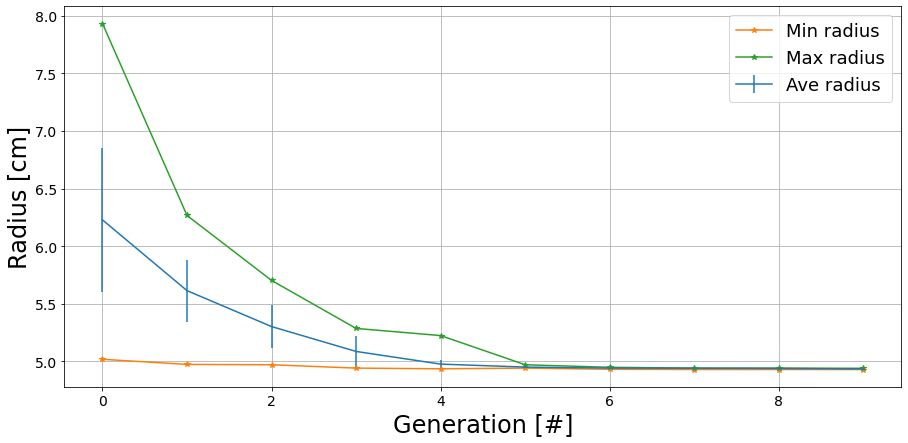

In [21]:
# Radius plot
logbook = cp["logbook"]
gen = logbook.select("gen")
rad_avg = get_ind_list(logbook.chapters["oup"].select("avg"), 0)
rad_std = get_ind_list(logbook.chapters["oup"].select("std"), 0)
rad_min = get_ind_list(logbook.chapters["oup"].select("min"), 0)
rad_max = get_ind_list(logbook.chapters["oup"].select("max"), 0)
fig, ax = plt.subplots(figsize=(15,7))
ax.errorbar(gen, rad_avg, yerr=rad_std, label="Ave radius")
ax.plot(gen, rad_min, "*-", label="Min radius")
ax.plot(gen, rad_max, "*-", label="Max radius")
ax.set_xlabel("Generation [#]", fontsize=24)
ax.set_ylabel("Radius [cm]", fontsize=24)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
fig.savefig('radius-convergence.png',bbox_inches='tight', dpi=300)

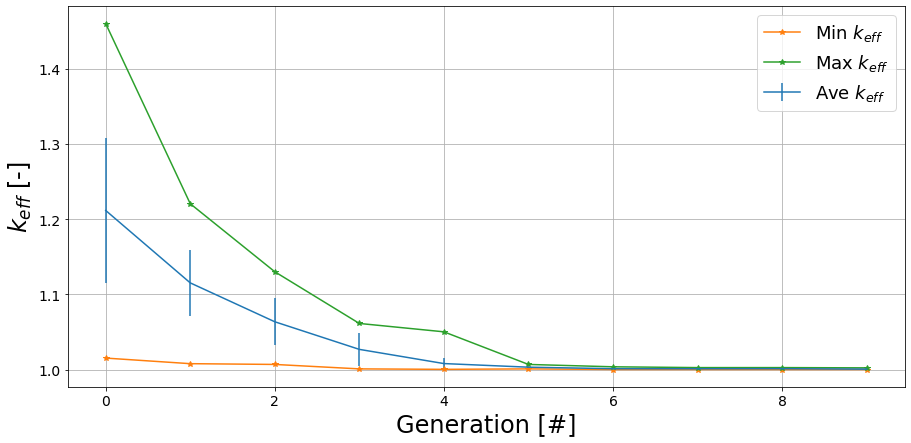

In [22]:
# keff plot
logbook = cp["logbook"]
gen = logbook.select("gen")
keff_avg = get_ind_list(logbook.chapters["oup"].select("avg"), 1)
keff_std = get_ind_list(logbook.chapters["oup"].select("std"), 1)
keff_min = get_ind_list(logbook.chapters["oup"].select("min"), 1)
keff_max = get_ind_list(logbook.chapters["oup"].select("max"), 1)
fig, ax = plt.subplots(figsize=(15,7))
ax.errorbar(gen, keff_avg, yerr=keff_std, label="Ave $k_{eff}$")
ax.plot(gen, keff_min, "*-", label="Min $k_{eff}$")
ax.plot(gen, keff_max, "*-", label="Max $k_{eff}$")
ax.set_xlabel("Generation [#]", fontsize=24)
ax.set_ylabel("$k_{eff}$ [-]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
fig.savefig('keff-convergence.png',bbox_inches='tight', dpi=300)

In [25]:
print("Final Generation's Average Radius:", round(rad_avg[-1],2), "cm")

Final Generation's Average Radius: 4.93 cm


# ROLLO's average radius values converged to 4.93cm, showing that ROLLO successfully found the critical radius.  